In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

В этой тетрадке собраны baselines и условие задачи.

#Примеры рядов

Открываем файл с временными рядами

In [3]:
data_full_1_104 = pd.read_csv('data_full_1_104.csv')
data_full_1_104.irow(range(0,5))

,Unnamed: 0,ID,DiskSize,Creation,First,StartTime,Now,1,2,3,...,95,96,97,98,99,100,101,102,103,104
0,0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0.635799,104591,104670,104660,104764,0,0,0,...,0,0,0,0,0,0,0,0,0,134
1,1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,2.819260,104607,104676,104660,104764,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,1.370105,104607,104666,104660,104764,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,3.490704,104607,104740,104660,104764,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0.289290,104607,104685,104660,104764,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Рисуем несколько рядов

In [4]:
from sklearn.metrics import roc_curve, auc

In [5]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [6]:
def get_auc(clf, X_test, y_test):
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    return auc(fpr, tpr)

## Trying to make use of previously gotten probabilities

In [294]:
n = 3000
k = 10

In [295]:
rows = np.random.choice(data_full_1_104.index.values, n)
fullset = data_full_1_104[[str(x) for x in range(1, 105)]].ix[rows]
fullset.reset_index(inplace=True)
fullset.drop(['index'], axis=1, inplace=True)

In [296]:
for i in xrange(1, 27) :
    fullset['y'+str(i)] = (((fullset[[str(x) for x in range(52+i, 78+i)]]).sum(axis=1)>0)*1.).astype(np.float)

In [297]:
fullset.head()

,1,2,3,4,5,6,7,8,9,10,...,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [298]:
probas = []
for startweek in xrange(1, 27) :
    x = fullset[[str(x) for x in range(startweek, startweek + 52)]] 
    y = fullset['y' + str(startweek)].values
    #indexes = range(n)
    #np.random.shuffle(indexes)
    parts = np.array(partition(indexes, k))
    proba = np.array([])
    for i in xrange(k):
        test = parts[i]
        train = np.concatenate(parts[np.delete(range(k), i)])
        _rfc = RFC(n_estimators=300)
        _rfc.fit(x.ix[train].values.astype(np.float64), y[train])
        proba = np.concatenate([proba, _rfc.predict_proba(x.ix[test].values.astype(np.float64)).T[1]])
    #probas.append(proba[indexes])
    probas.append(proba)

In [299]:
probas = np.array(probas)

In [244]:
arr = np.array([1, 2, 3, 4, 5])
arr[np.array([2, 4, 0, 3, 1])]

array([3, 5, 1, 4, 2])

In [300]:
np.shape(probas)

(26, 3000)

In [301]:
probas1_23 = probas[:23].T #probabilities of usage for weeks (53-79) to (75 - 101) 

In [302]:
probas2_24 = probas[1:24].T

In [303]:
probas3_25 = probas[2:25].T

In [304]:
probas4_26 = probas[3:26].T #probabilities of usage for weeks (56-82) to (78 - 104) 

In [305]:
from sklearn.ensemble import RandomForestClassifier as RFC
_rfc = RFC(n_estimators=300)
_rfc.fit(probas1_23, fullset['y23'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [306]:
print get_auc(_rfc, probas2_24, fullset['y24'].values)

0.810380540453


In [307]:
print get_auc(_rfc, probas3_25, fullset['y25'].values)

0.805525067194


In [308]:
print get_auc(_rfc, probas4_26, fullset['y26'].values)

0.787718750673


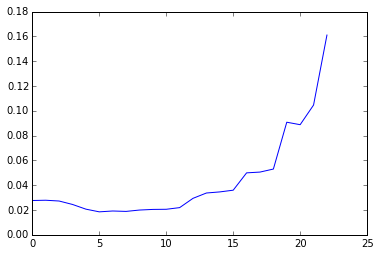

In [309]:
plt.plot(_rfc.feature_importances_)

In [311]:
from nolearn.dbn import DBN
_dbn = DBN([probas1_23.shape[1], 200, 120, 2], learn_rates = 0.1, epochs=300)
_dbn.fit(probas1_23, fullset['y23'].values)

#### DBN вообще пошёл на разгон :)

In [313]:
print get_auc(_dbn, probas2_24, fullset['y24'].values)

0.761922191129


In [314]:
print get_auc(_dbn, probas3_25, fullset['y25'].values)

0.775493740877


In [312]:
print get_auc(_dbn, probas4_26, fullset['y26'].values)

0.780162190479


In [156]:
def partition(lst, n):
    q, r = divmod(len(lst), n)
    indices = [q*i + min(i, r) for i in xrange(n+1)]
    return [lst[indices[i]:indices[i+1]] for i in xrange(n)]